## Import Libraries

- mmdet version: https://github.com/open-mmlab/mmdetection/tree/v0.6rc0

In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

## Anchor generate
- code from: https://github.com/open-mmlab/mmdetection/blob/v0.6rc0/mmdet/core/anchor/anchor_generator.py

In [ ]:
def meshgrid(x, y):
    xx = x.repeat(len(y))
    yy = y.view(-1, 1).repeat(1, len(x)).view(-1)
    return xx, yy

def gen_base_anchors(base_size, ratios, scales):
    w = base_size
    h = base_size
    
    x_ctr = 0.5 * (w - 1)
    y_ctr = 0.5 * (h - 1)

    h_ratios = torch.sqrt(ratios)
    w_ratios = 1 / h_ratios
    ws = (w * w_ratios[:, None] * scales[None, :]).view(-1)
    hs = (h * h_ratios[:, None] * scales[None, :]).view(-1)

    base_anchors = torch.stack(
        [
            x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1),
            x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)
        ],
        dim=-1).round()
    return base_anchors

def grid_anchors(base_anchors, featmap_size, stride=16, device='cuda'):
    base_anchors = base_anchors.to(device)

    feat_h, feat_w = featmap_size
    shift_x = torch.arange(0, feat_w, device=device) * stride
    shift_y = torch.arange(0, feat_h, device=device) * stride
    shift_xx, shift_yy = meshgrid(shift_x, shift_y)
    shifts = torch.stack([shift_xx, shift_yy, shift_xx, shift_yy], dim=-1)
    shifts = shifts.type_as(base_anchors)

    all_anchors = base_anchors[None, :, :] + shifts[:, None, :]
    all_anchors = all_anchors.view(-1, 4)
    return all_anchors, shifts

def valid_flags(featmap_size, valid_size, num_base_anchors, device='cuda'):
    feat_h, feat_w = featmap_size
    valid_h, valid_w = valid_size
    assert valid_h <= feat_h and valid_w <= feat_w
    valid_x = torch.zeros(feat_w, dtype=torch.uint8, device=device)
    valid_y = torch.zeros(feat_h, dtype=torch.uint8, device=device)
    valid_x[:valid_w] = 1
    valid_y[:valid_h] = 1
    valid_xx, valid_yy = meshgrid(valid_x, valid_y)
    valid = valid_xx & valid_yy
    valid = valid[:, None].expand(
        valid.size(0), num_base_anchors).contiguous().view(-1)
    return valid

- code from: https://github.com/open-mmlab/mmdetection/blob/f2cfa86b4294e2593429adccce64bfd049a27651/mmdet/models/anchor_heads/anchor_head.py#L89-L126

In [2]:
def get_anchors(image_shape, featmap_size, anchor_stride, scales, ratios, device='cuda'):
    num_base_anchors = len(scales) * len(ratios)
    base_anchors = gen_base_anchors(base_size, ratios, scales)
    anchors, shifts = grid_anchors(base_anchors, featmap_size, anchor_stride, device)
    
    feat_h, feat_w = featmap_size
    h, w = image_shape[: 2]
    valid_feat_h = min(int(np.ceil(h / anchor_stride)), feat_h)
    valid_feat_w = min(int(np.ceil(w / anchor_stride)), feat_w)
    valid_size = [valid_feat_h, valid_feat_w]
    flags = valid_flags(featmap_size, valid_size, num_base_anchors, device)    
    return anchors, flags

## Anchor -> gt assign
- code from: https://github.com/open-mmlab/mmdetection/blob/f2cfa86b4294e2593429adccce64bfd049a27651/mmdet/core/bbox/assigners/max_iou_assigner.py#L87-L146

In [3]:
def assign_wrt_overlaps(overlaps, 
                        pos_iou_thr=0.5,
                        neg_iou_thr=0.4,
                        min_pos_iou=0.0):
    """Assign w.r.t. the overlaps of bboxes with gts.

    Args:
        overlaps (Tensor): Overlaps between k gt_bboxes and n bboxes,
            shape(k, n).
        gt_labels (Tensor, optional): Labels of k gt_bboxes, shape (k, ).

    Returns:
        :obj:`AssignResult`: The assign result.
    """        
    if overlaps.numel() == 0:
        raise ValueError('No gt or proposals')

    num_gts, num_bboxes = overlaps.size(0), overlaps.size(1)

    # 1. assign -1 by default
    assigned_gt_inds = overlaps.new_full(
        (num_bboxes, ), -1, dtype=torch.long)

    # for each anchor, which gt best overlaps with it
    # for each anchor, the max iou of all gts
    max_overlaps, argmax_overlaps = overlaps.max(dim=0)
    # for each gt, which anchor best overlaps with it
    # for each gt, the max iou of all proposals
    gt_max_overlaps, gt_argmax_overlaps = overlaps.max(dim=1)

    # 2. assign negative: below
    if isinstance(neg_iou_thr, float):
        assigned_gt_inds[(max_overlaps >= 0)
                         & (max_overlaps < neg_iou_thr)] = 0
    elif isinstance(neg_iou_thr, tuple):
        assert len(neg_iou_thr) == 2
        assigned_gt_inds[(max_overlaps >= neg_iou_thr[0])
                         & (max_overlaps < neg_iou_thr[1])] = 0

    # 3. assign positive: above positive IoU threshold
    pos_inds = max_overlaps >= pos_iou_thr
    assigned_gt_inds[pos_inds] = argmax_overlaps[pos_inds] + 1

    # 4. assign fg: for each gt, proposals with highest IoU
    for i in range(num_gts):
        if gt_max_overlaps[i] >= min_pos_iou:
            max_iou_inds = overlaps[i, :] == gt_max_overlaps[i]
            assigned_gt_inds[max_iou_inds] = i + 1
                
    return num_gts, assigned_gt_inds, max_overlaps

def bbox_overlaps(bboxes1, bboxes2):
    """Calculate overlap between two set of bboxes.

    If ``is_aligned`` is ``False``, then calculate the ious between each bbox
    of bboxes1 and bboxes2, otherwise the ious between each aligned pair of
    bboxes1 and bboxes2.

    Args:
        bboxes1 (Tensor): shape (m, 4)
        bboxes2 (Tensor): shape (n, 4), if is_aligned is ``True``, then m and n
            must be equal.
        mode (str): "iou" (intersection over union) or iof (intersection over
            foreground).

    Returns:
        ious(Tensor): shape (m, n) if is_aligned == False else shape (m, 1)
    """

    rows = bboxes1.size(0)
    cols = bboxes2.size(0)

    if rows * cols == 0:
        return bboxes1.new(rows, 1) if is_aligned else bboxes1.new(rows, cols)

    lt = torch.max(bboxes1[:, None, :2], bboxes2[:, :2])  # [rows, cols, 2]
    rb = torch.min(bboxes1[:, None, 2:], bboxes2[:, 2:])  # [rows, cols, 2]

    wh = (rb - lt + 1).clamp(min=0)  # [rows, cols, 2]
    overlap = wh[:, :, 0] * wh[:, :, 1]
    area1 = (bboxes1[:, 2] - bboxes1[:, 0] + 1) * (
        bboxes1[:, 3] - bboxes1[:, 1] + 1)

    area2 = (bboxes2[:, 2] - bboxes2[:, 0] + 1) * (
        bboxes2[:, 3] - bboxes2[:, 1] + 1)
    ious = overlap / (area1[:, None] + area2 - overlap)
    
    return ious

## delta-bbox conversion
- code from: https://github.com/open-mmlab/mmdetection/blob/f2cfa86b4294e2593429adccce64bfd049a27651/mmdet/core/bbox/transforms.py#L6-L68

In [4]:
def bbox2delta(proposals, gt, means=[0, 0, 0, 0], stds=[1, 1, 1, 1]):
    assert proposals.size() == gt.size()

    proposals = proposals.float()
    gt = gt.float()
    px = (proposals[..., 0] + proposals[..., 2]) * 0.5
    py = (proposals[..., 1] + proposals[..., 3]) * 0.5
    pw = proposals[..., 2] - proposals[..., 0] + 1.0
    ph = proposals[..., 3] - proposals[..., 1] + 1.0

    gx = (gt[..., 0] + gt[..., 2]) * 0.5
    gy = (gt[..., 1] + gt[..., 3]) * 0.5
    gw = gt[..., 2] - gt[..., 0] + 1.0
    gh = gt[..., 3] - gt[..., 1] + 1.0

    dx = (gx - px) / pw
    dy = (gy - py) / ph
    dw = torch.log(gw / pw)
    dh = torch.log(gh / ph)
    deltas = torch.stack([dx, dy, dw, dh], dim=-1)

    means = deltas.new_tensor(means).unsqueeze(0)
    stds = deltas.new_tensor(stds).unsqueeze(0)
    deltas = deltas.sub_(means).div_(stds)

    return deltas

def delta2bbox(rois,
               deltas,
               means=[0, 0, 0, 0],
               stds=[1, 1, 1, 1],
               max_shape=None):
    means = deltas.new_tensor(means).repeat(1, deltas.size(1) // 4)
    stds = deltas.new_tensor(stds).repeat(1, deltas.size(1) // 4)
    denorm_deltas = deltas * stds + means
    dx = denorm_deltas[:, 0::4]
    dy = denorm_deltas[:, 1::4]
    dw = denorm_deltas[:, 2::4]
    dh = denorm_deltas[:, 3::4]
    px = ((rois[:, 0] + rois[:, 2]) * 0.5).unsqueeze(1).expand_as(dx)
    py = ((rois[:, 1] + rois[:, 3]) * 0.5).unsqueeze(1).expand_as(dy)
    pw = (rois[:, 2] - rois[:, 0] + 1.0).unsqueeze(1).expand_as(dw)
    ph = (rois[:, 3] - rois[:, 1] + 1.0).unsqueeze(1).expand_as(dh)
    gw = pw * dw.exp()
    gh = ph * dh.exp()
    gx = torch.addcmul(px, 1, pw, dx)  # gx = px + pw * dx
    gy = torch.addcmul(py, 1, ph, dy)  # gy = py + ph * dy
    x1 = gx - gw * 0.5 + 0.5
    y1 = gy - gh * 0.5 + 0.5
    x2 = gx + gw * 0.5 - 0.5
    y2 = gy + gh * 0.5 - 0.5
    if max_shape is not None:
        x1 = x1.clamp(min=0, max=max_shape[1] - 1)
        y1 = y1.clamp(min=0, max=max_shape[0] - 1)
        x2 = x2.clamp(min=0, max=max_shape[1] - 1)
        y2 = y2.clamp(min=0, max=max_shape[0] - 1)
    bboxes = torch.stack([x1, y1, x2, y2], dim=-1).view_as(deltas)
    return bboxes

## Visualize

In [34]:
def prepare_base_figure(shape, grid_size, figsize=(20, 20)):    
    fig, ax = plt.subplots(figsize=figsize)

    loc = plticker.MultipleLocator(base=grid_size)
    ax.xaxis.set_major_locator(loc)
    ax.yaxis.set_major_locator(loc)
    
    ax.grid(which='major', axis='both', linestyle='--', color='w')
    return ax 


def draw_anchor_gt_overlaps(overlaps, grid_size=1, figsize=(20, 20)):    
    """Draw anchor overlaps w.r.t. gt bboxes"""
    grid_x, grid_y = overlaps.shape[:2]
    ax = prepare_base_figure(overlaps.shape, grid_size, figsize)
    ax.imshow(overlaps, extent=[0, grid_x, 0, grid_y])
    plt.margins(0)
    plt.title("overlap btw feature map reg prediction and gt")
    plt.show()

    
def draw_pos_assigned_bboxes(image_shape, grid_size, gt_bboxes_list, pos_bboxes, 
                             pos_pred_bboxes=None, figsize=(20, 20)):
    """Draw positive, negative bboxes."""
    background_image = np.zeros(image_shape)
    ax = prepare_base_figure(image_shape, grid_size, figsize)
    
    for gt_bbox in gt_bboxes_list:
        x1, y1, x2, y2 = gt_bbox
        cv2.rectangle(background_image, (x1, y1), (x2, y2), (0, 0, 255), 1)
        
    for pos_bbox in pos_bboxes:
        x1, y1, x2, y2 = pos_bbox
        cv2.rectangle(background_image, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    if pos_pred_bboxes is not None:
        for pos_pred_bbox in pos_pred_bboxes:
            x1, y1, x2, y2 = pos_pred_bbox
            cv2.rectangle(background_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
    
    image_x, image_y = image_shape[:2]
    ax.imshow(background_image, extent=[0, image_x, 0, image_y])        
    plt.title("gt, prediction, anchor")
    plt.show()    

## Settings
- gt_bboxes_list box를 더 크게 잡으면 다양한 positive anchor 후보들이 생기는 것을 확인할 수 있다.
- scale, ratio를 변경시키면 anchor box의 형태를 편향되게 만들 수 있다.
- `base_size`는 `image_size` // `featmap_size`의 값을 주로 갖는데, 이보다 크거나 작으면 전체 image를 커버하지 못하거나 image를 넘어서 커버하게 될 수 있다.

In [302]:
# 1개 featmap에 대해서만 분석을 진행합니다. 
# multi-level (FPN)이 사용되는 경우는 뒤에서 보도록 하겠습니다. 

base_size = 16
anchor_stride = 16
scales = torch.Tensor([2, 4, 8])
ratios = torch.Tensor([0.5, 1.0, 2.0])
featmap_size = [32, 32]
device = 'cpu'
image_shape = [512, 512, 3]

# x1y1x2y2
gt_bboxes_list = torch.FloatTensor([[16, 16, 16*3, 16*3]]).to(device)

In [303]:
# base_anchors = gen_base_anchors(base_size, ratios, scales)
# all_anchors, shifts = grid_anchors(base_anchors, featmap_size, anchor_stride, device)

In [304]:
anchors, flags = get_anchors(image_shape, featmap_size, anchor_stride, scales, ratios, device)

In [305]:
assert anchors.shape[0] == 32 * 32 * 9  # feature map 32x32 각 pixel에 9개의 anchors
assert len(flags) == len(anchors)  # anchor를 사용할 지 말지 결정하는 flags와 anchors의 개수는 같아야 합니다.

In [306]:
overlaps = bbox_overlaps(gt_bboxes_list, anchors)  

In [307]:
assert overlaps.shape == (len(gt_bboxes_list), anchors.shape[0])

- gt 중점 표시

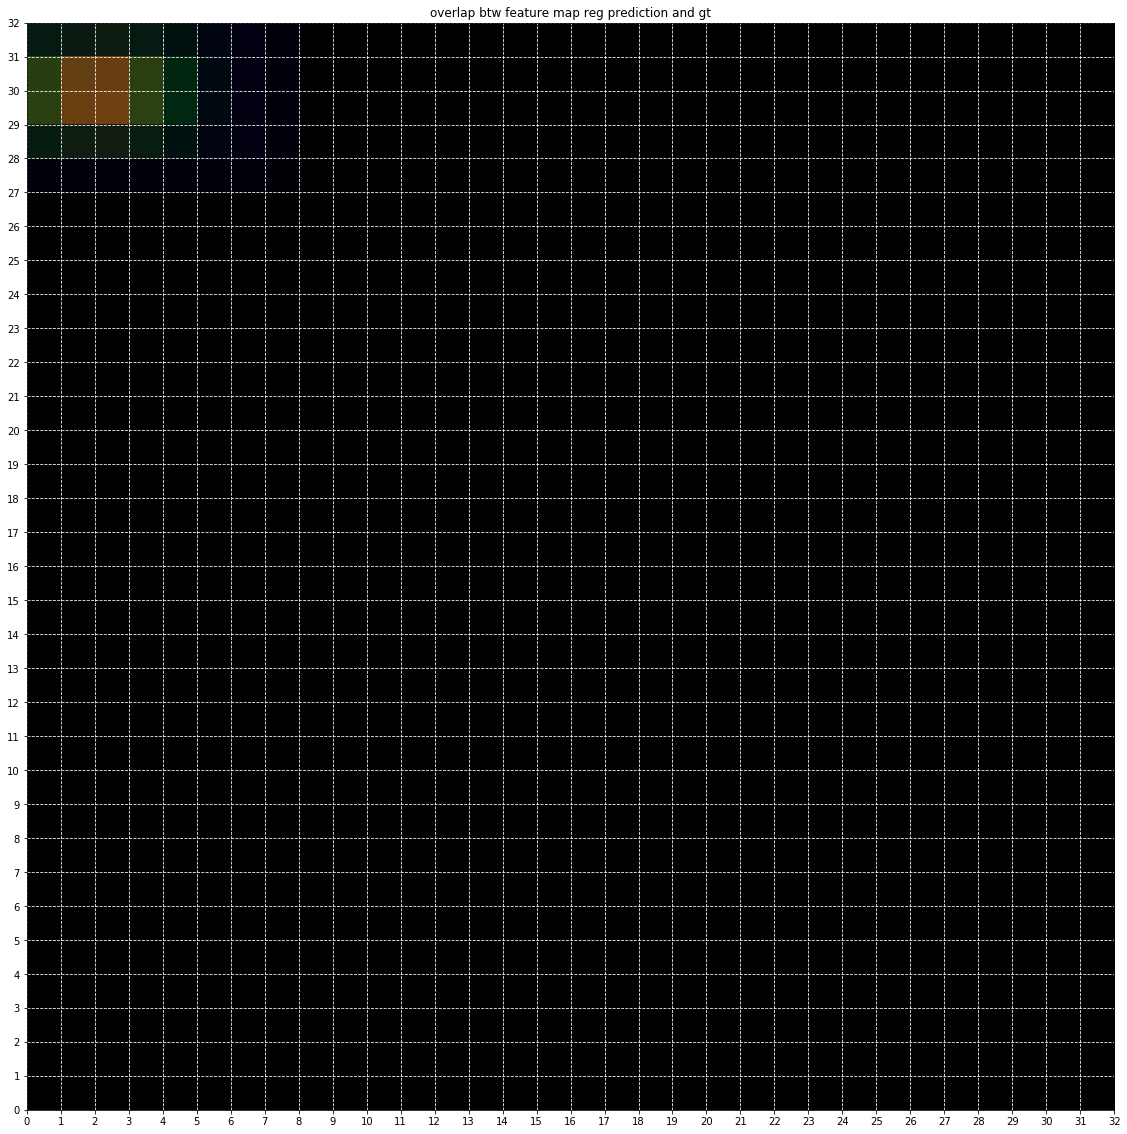

In [308]:
# overlap을 시각적으로 나타냈을 때, gt 근처 영역이 가장 많이 겹치게 나타납니다.
overlaps_npy = overlaps.reshape(32, 32, 9).cpu().numpy()
draw_anchor_gt_overlaps(overlaps_npy[..., :3])

In [309]:
# gt와의 overlap에 따라 pos, negative를 배정.
num_gts, assigned_gt_inds, max_overlaps = assign_wrt_overlaps(overlaps)

In [310]:
pos_inds = torch.nonzero(assigned_gt_inds > 0).squeeze(-1).unique()  # positive indices
neg_inds = torch.nonzero(assigned_gt_inds == 0).squeeze(-1).unique()  # negative indices

In [311]:
bboxes = anchors  # bboxes
pos_bboxes = bboxes[pos_inds]  # positive boxes
pos_assigned_gt_inds = assigned_gt_inds[pos_inds] - 1
pos_gt_bboxes = gt_bboxes_list[pos_assigned_gt_inds, :]

여기에서 보여줄 내용은 positive sample에 대해서 regression에 관한 내용만 추가.

positive, negative 둘 다에 대한 classification 내용을 넣을지 말지는 고민 중. (내용이 커지면 핵심 이해하기가 어려운데 다 포함이 안 되면더 헷갈릴 수도 있어서 trade-off 고민해야 할 듯.)

In [312]:
# target_deltas는 특정 pos_inds에 대한 것이며 이 inds에 할당된 anchor를 기준으로만 loss가 계산이 되게 된다.
target_deltas = bbox2delta(pos_bboxes, pos_gt_bboxes)

In [313]:
# check if delta has same bbox value when reversed
bboxes_reversed = delta2bbox(pos_bboxes, target_deltas)
assert torch.equal(bboxes_reversed[0], gt_bboxes_list[0])

## Misc

prediction 부분 임의로 만들어서 loss를 계산하고, 위치 변화에 따라서 얼마나 나아지는 지 보여줘야 할 듯.

In [314]:
# assume our anchor_head network predicted delta
def predict_pos_anchor(shape, target_deltas, seed=99):
    # predicted value
    torch.manual_seed(seed)
    pos_delta_pred = target_deltas + torch.rand(target_deltas.shape) / 5
    return pos_delta_pred

원칙적으로는 anchor prediction을 구하고 그 중에 `pos_inds`에 해당하는 값만 가져오는 과정을 거쳐야 하는데, 그 과정을 넣으면 더 헷갈릴 듯해서 일단 skip 했다고 명시만 해놓음.

In [315]:
# delta prediction for positive indices (will update weight)
pos_delta_pred = predict_pos_anchor(anchors.shape, target_deltas)
pos_bboxes_pred = delta2bbox(pos_bboxes, pos_delta_pred)

In [316]:
target_deltas

tensor([[-0.3409, -0.1630,  0.4055, -0.3321],
        [-0.1630, -0.3409, -0.3321,  0.4055]])

In [317]:
pos_delta_pred

tensor([[-0.3202,  0.0310,  0.5951, -0.1364],
        [-0.0977, -0.1569, -0.3221,  0.4971]])

In [318]:
gt_bboxes_list  # gt

tensor([[16., 16., 48., 48.]])

In [319]:
pos_bboxes_pred  # prediction

tensor([[13.0096, 21.3579, 51.8995, 60.4929],
        [18.8395, 18.4642, 51.1730, 53.6320]])

- code from: https://github.com/open-mmlab/mmdetection/blob/f2cfa86b4294e2593429adccce64bfd049a27651/mmdet/core/loss/losses.py#L76-L89

In [320]:
def smooth_l1_loss(pred, target, beta=1.0):
    assert beta > 0
    assert pred.size() == target.size() and target.numel() > 0
    diff = torch.abs(pred - target)
    loss = torch.where(diff < beta, 0.5 * diff * diff / beta,
                       diff - 0.5 * beta)
    return loss.sum()

In [321]:
reg_loss = smooth_l1_loss(pos_delta_pred, target_deltas, beta=1.0)

In [322]:
reg_loss

tensor(0.0795)

- gt 중점 표시, 좌표 표시 
- anchor에 몇 번째 index인지 표시, 좌표 표시 
- anchor의 delta 계산, 표시
- 예측 값에 대한 delta
- 예측 값 위치 환산

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


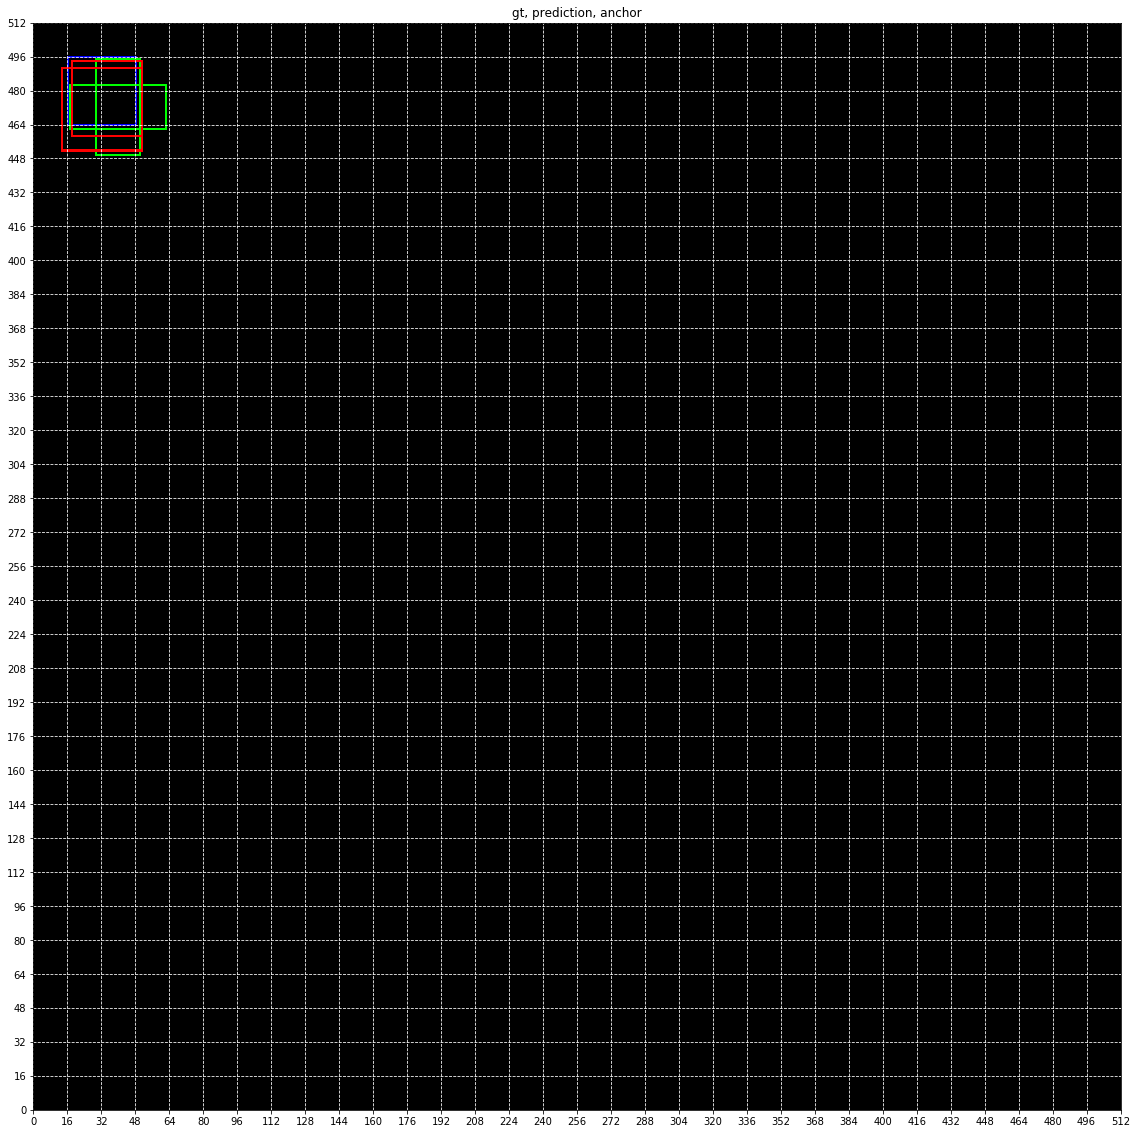

In [323]:
# blue: gt, green: anchor, red: prediction
draw_pos_assigned_bboxes(image_shape, base_size, gt_bboxes_list, pos_bboxes, pos_bboxes_pred)